In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pastas as ps


In [4]:
class HantushOld(ps.rfunc.RfuncBase):
    """
    The Hantush well function.

    Parameters
    ----------
    up: bool or None, optional
        indicates whether a positive stress will cause the head to go up
        (True, default) or down (False), if None the head can go both ways.
    meanstress: float
        mean value of the stress, used to set the initial value such that
        the final step times the mean stress equals 1
    cutoff: float
        proportion after which the step function is cut off. default is 0.999.

    Notes
    -----
    The Hantush well function is explained in [hantush_1955]_, [veling_2010]_
    and [asmuth_2008]_. It's parameters are:

    .. math:: p[0] = A = \\frac{1}{4 \\pi kD}
    .. math:: p[1] = \\rho = \\frac{r}{\\lambda}
    .. math:: p[2] = cS

    where :math:`\\lambda = \\sqrt{kDc}`

    References
    ----------
    .. [hantush_1955] Hantush, M. S., & Jacob, C. E. (1955). Non‐steady
       radial flow in an infinite leaky aquifer. Eos, Transactions American
       Geophysical Union, 36(1), 95-100.

    .. [veling_2010] Veling, E. J. M., & Maas, C. (2010). Hantush well function
       revisited. Journal of hydrology, 393(3), 381-388.

    .. [asmuth_2008] Von Asmuth, J. R., Maas, K., Bakker, M., & Petersen,
       J. (2008). Modeling time series of ground water head fluctuations
       subjected to multiple stresses. Ground Water, 46(1), 30-40.

    """
    _name = "HantushOld"

    def __init__(self, up=False, meanstress=1, cutoff=0.999):
        RfuncBase.__init__(self, up, meanstress, cutoff)
        self.nparam = 3

    def get_init_parameters(self, name):
        parameters = DataFrame(
            columns=['initial', 'pmin', 'pmax', 'vary', 'name'])
        if self.up:
            parameters.loc[name + '_A'] = (1 / self.meanstress, 0,
                                           100 / self.meanstress, True, name)
        elif self.up is False:
            parameters.loc[name + '_A'] = (-1 / self.meanstress,
                                           -100 / self.meanstress, 0, True,
                                           name)
        else:
            parameters.loc[name + '_A'] = (1 / self.meanstress,
                                           np.nan, np.nan, True, name)

        parameters.loc[name + '_rho'] = (1, 1e-4, 10, True, name)
        parameters.loc[name + '_cS'] = (100, 1e-3, 1e4, True, name)
        return parameters

    def get_tmax(self, p, cutoff=None):
        # approximate formula for tmax
        if cutoff is None:
            cutoff = self.cutoff
        rho = p[1]
        cS = p[2]
        k0rho = k0(rho)
        return lambertw(1 / ((1 - cutoff) * k0rho)).real * cS

    def gain(self, p):
        return p[0]

    def step(self, p, dt=1, cutoff=None, maxtmax=None):
        rho = p[1]
        cS = p[2]
        k0rho = k0(rho)
        t = self.get_t(p, dt, cutoff, maxtmax)
        tau = t / cS
        tau1 = tau[tau < rho / 2]
        tau2 = tau[tau >= rho / 2]
        w = (exp1(rho) - k0rho) / (exp1(rho) - exp1(rho / 2))
        F = np.zeros_like(tau)
        F[tau < rho / 2] = w * exp1(rho ** 2 / (4 * tau1)) - (w - 1) * exp1(
            tau1 + rho ** 2 / (4 * tau1))
        F[tau >= rho / 2] = 2 * k0rho - w * exp1(tau2) + (w - 1) * exp1(
            tau2 + rho ** 2 / (4 * tau2))
        return p[0] * F / (2 * k0rho)

In [5]:
class PolderOld(ps.rfunc.RfuncBase):
    """The Polder function, for a river in a confined aquifer,
    overlain by an aquitard with aquiferous ditches.

    Notes
    -----
    The Polder function is explained in [polder]_. It's parameters are:

    .. math:: p[0] = \\frac{x}{2\\lambda}
    .. math:: p[1] = \\sqrt{\\frac{1}{cS}}

    where :math:`\\lambda = \\sqrt{\\frac{kD}{c}}`

    References
    ----------
    .. [polder] http://grondwaterformules.nl/index.php/formules/waterloop
    /deklaag-met-sloten

    """
    _name = "PolderOld"

    def __init__(self, up=True, meanstress=1, cutoff=0.999):
        RfuncBase.__init__(self, up, meanstress, cutoff)
        self.nparam = 3

    def get_init_parameters(self, name):
        parameters = DataFrame(
            columns=['initial', 'pmin', 'pmax', 'vary', 'name'])
        A_init = 1
        a_init = 1
        b_init = 1
        parameters.loc[name + '_A'] = (A_init, 0, 2, False, name)
        parameters.loc[name + '_a'] = (a_init, 0, 100, True, name)
        parameters.loc[name + '_b'] = (b_init, 0, 10, True, name)
        return parameters

    def get_tmax(self, p, cutoff=None):
        if cutoff is None:
            cutoff = self.cutoff
        A, p0, sqrtp1 = p
        p1 = sqrtp1 ** 2
        inverfc = erfcinv(2 * cutoff)
        y = ((-inverfc + np.sqrt(inverfc ** 2 + 4 * p0)) / 2)
        tmax = (y / np.sqrt(p1)) ** 2
        return tmax

    def gain(self, p):
        # the steady state solution of Mazure
        g = p[0] * np.exp(-2 * p[1])
        if not self.up:
            g = -g
        return g

    def step(self, p, dt=1, cutoff=None, maxtmax=None):
        t = self.get_t(p, dt, cutoff, maxtmax)
        s = p[0] * self.polder_function(p[1], p[2] * np.sqrt(t))
        if not self.up:
            s = -s
        return s

    @staticmethod
    def polder_function(x, y):
        s = 0.5 * np.exp(2 * x) * erfc(x / y + y) + \
            0.5 * np.exp(-2 * x) * erfc(x / y - y)
        return s


In [6]:
gamma = ps.Gamma()
exp = ps.Exponential()
fourp = ps.FourParam()
hantush = ps.Hantush()
hantushold = ps.HantushOld()
polder = ps.Polder()
polderold = ps.PolderOld()

## Comparison of all response functions that can be written as the 4-parameter function

### Most impulse response functions can be written in the same form
Four parameter function
\begin{equation}
h(t) = At^{n-1}\exp(-t/a -ab/t)
\end{equation}
Gamma impulse response function
\begin{equation}
h(t) = At^{n-1}\exp(-t/a) \qquad (b=0)
\end{equation}
Exponential impulse response function
\begin{equation}
h(t) = A\exp(-t/a) \qquad (n=1 \quad \& \quad b=0)
\end{equation}
Hantush impulse response function
\begin{equation}
h(t) = At^{-1}\exp(-t/a - ab/t) \qquad (n=0)
\end{equation}
Polder impulse response function
\begin{equation}
h(t) = At^{-3/2}\exp(-t/a -b/t) \qquad (n=-1/2)
\end{equation}

#### Four parameter function
Four-parameter impulse function as programmed
\begin{equation}
h(t) = At^{n-1}\exp(-t/a -ab/t)
\end{equation}
The step function is normalized so that the step function approaches $A$ for large $t$. 

### Four parameter function for different values of $b$

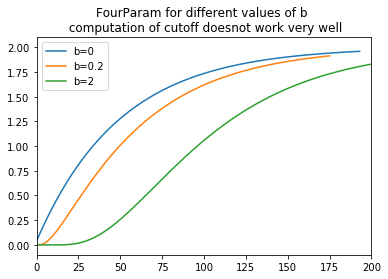

In [7]:
a = 50
for b in [0, 0.2, 2]:
    fp = fourp.step([2, 1, a, b], dt=1, cutoff=0.95) # A=2, n=1, a=50
    plt.plot(fp, label=f'b={b}')
    plt.xlim(0, 200)
plt.legend()
plt.title('FourParam for different values of b \n computation of cutoff doesnot work very well');

### Four parameter function compared to Gamma and Exponential

Gamma impulse response function as programmed
\begin{equation}
h(t) = At^{n-1}\exp(-t/a)
\end{equation}
Exponential impulse response function as programmed
\begin{equation}
h(t) = A\exp(-t/a)
\end{equation}
The step function is normalized so that the step function approaches $A$ for large $t$. 

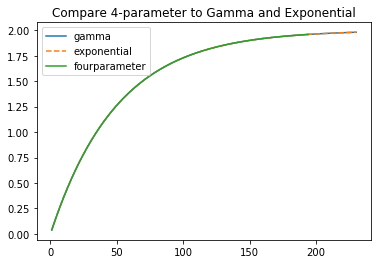

In [8]:
g = gamma.step([2, 1, 50], dt=1, cutoff=0.99) # A=2, n=1, a=50
e = exp.step([2, 50], dt=1, cutoff=0.99) # A=2, a=50
fp = fourp.step([2, 1, 50, 0], dt=1, cutoff=0.95) # A=2, n=1, a=50, b=0
plt.plot(np.arange(1, len(g) + 1), g, label='gamma')
plt.plot(np.arange(1, len(e) + 1), e, '--', label='exponential')
plt.plot(np.arange(1, len(fp) + 1), fp, label='fourparameter')
plt.legend()
plt.title('Compare 4-parameter to Gamma and Exponential');

#### Four parameter function compared to Hantush

Hantush impulse response function as programmed
\begin{equation}
h(t) = At^{-1}\exp(-t/a - ab/t)
\end{equation}
The Hantush step function is scaled such that the gain equals AK$_0(\sqrt{4b})$

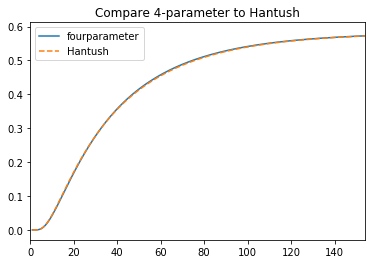

In [9]:
from scipy.special import k0
A = 2
a = 50
b = 0.4
# relationship between cS, rho and a, b
cS = a
rho = np.sqrt(4 * b)
fp = fourp.step([A, 1e-6, a, b], dt=1, cutoff=0.95) * k0(np.sqrt(4 * b))
ht = hantush.step([A, a, b], dt=1, cutoff=0.95) # A=2, a=50, b=0.4
plt.plot(np.arange(1, len(fp) + 1), fp, label='fourparameter')
plt.plot(np.arange(1, len(ht) + 1), ht, '--', label='Hantush')
plt.legend()
plt.xlim(0, len(ht))
plt.title('Compare 4-parameter to Hantush');

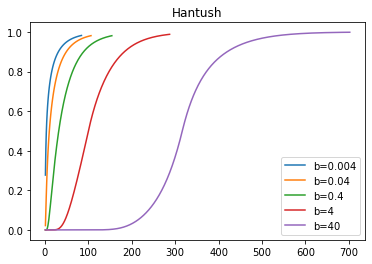

In [10]:
for b in [0.004, 0.04, 0.4, 4, 40]:
    h = hantush.step([2, 50, b], dt=1, cutoff=0.95) / hantush.gain([2, 50, b])
    plt.plot(np.arange(1, len(h) + 1), h, label=f'b={b}')
plt.legend()
plt.title('Hantush');

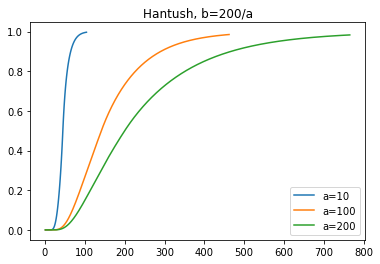

In [11]:
for a in [10, 100, 200]:
    h = hantush.step([2, a, 200 / a], dt=1, cutoff=0.95) / hantush.gain([2, a, 200 / a])
    plt.plot(np.arange(1, len(h) + 1), h, label=f'a={a}')
plt.legend()
plt.title('Hantush, b=200/a');

#### Hantush step function compared to classic Hantush function
The classic Hantush function is 
$$
h(r, t) = \frac{-Q}{4\pi T}\int_u  ^\infty  \exp\left(-y - \frac{r^2}{4  \lambda^2 y} \right) \frac{\text{d}y}{y} 
$$
where
$$
u=\frac{r^2 S}{4 T t}
$$
The parameters in Pastas are
$$
A = \frac{1}{4\pi T}
$$
$$
a = cS
$$
$$
b = \frac{r^2}{4\lambda^2}
$$
where $\lambda^2=cT$.

In [12]:
from scipy.integrate import quad

def integrand_hantush(y, r, lab):
    return np.exp(-y - r ** 2 / (4 * lab ** 2 * y)) / y

def hantush_classic(t=1, r=1, Q=1, T=100, S=1e-4, c=1000):
    lab = np.sqrt(T * c)
    u = r ** 2 * S / (4 * T * t)
    F = quad(integrand_hantush, u, np.inf, args=(r, lab))[0]
    return -Q / (4 * np.pi * T) * F

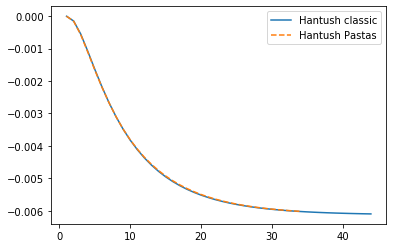

In [13]:
c = 1000 # d
S = 0.01 # -
T = 100 # m^2/d
r = 500 # m
Q = 20 # m^3/d
#
t = np.arange(1, 45)
h_hantush_classic = np.zeros(len(t))
for i in range(len(t)):
    h_hantush_classic[i] = hantush_classic(t[i], r=r, Q=20, T=T, S=S, c=c)
#
a = c * S
b = r ** 2 / (4 * T * c)
ht = hantush.step([1, a, b], dt=1, cutoff=0.95) * (-Q / (2 * np.pi * T))
#
plt.plot(t, h_hantush_classic, label='Hantush classic')
plt.plot(np.arange(1, len(ht) + 1), ht, '--', label='Hantush Pastas')
plt.legend();

#### Four parameter function compared to Polder

Polder impulse response function as programmed
\begin{equation}
h(t) = At^{-3/2}\exp(-t/a -b/t)
\end{equation}
The Polder function is scaled such that the gain equals
$A\exp(-x/\lambda)=\exp\left(-2\sqrt{b}\right)$

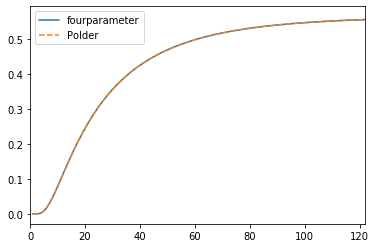

In [14]:
a = 50 
b = 0.4
A = 2
p1 = 1 / a
p0 = np.sqrt(p1 * b)
fp = fourp.step([A, -0.5, a, b], dt=1, cutoff=0.95) * np.exp(-2 * np.sqrt(b)) # A=1, n=-0.5, a=50, b=20
t = np.arange(1, 200)
pd = polder.step([A, a, b], dt=1, cutoff=0.95)
plt.plot(np.arange(1, len(fp) + 1), fp, label='fourparameter')
plt.plot(np.arange(1, len(pd) + 1), pd, '--', label='Polder')
plt.xlim(0, len(pd))
plt.legend();

#### Polder step function compared to classic polder function
The classic polder function is (Eq. 123.32 in Bruggeman, 1999)
$$
h(t) = \Delta h \text{P}\left(\frac{x}{2\lambda}, \sqrt{\frac{t}{cS}}\right)
$$
where P is the polder function.

In [15]:
from scipy.special import erfc

def polder_classic(t, x, T, S, c):
    X = x / (2 * np.sqrt(T * c))
    Y = np.sqrt(t / (c * S))
    rv = 0.5 * np.exp(2 * X) * erfc(X / Y + Y) + \
         0.5 * np.exp(-2 * X) * erfc(X / Y - Y)
    return rv

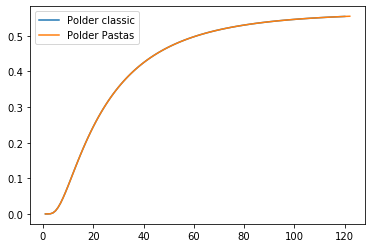

In [16]:
delh = 2
T = 20
c = 5000
S = 0.01
x = 400
x / np.sqrt(c * T)
t = np.arange(1, 121)
h_polder_classic = np.zeros(len(t))
for i in range(len(t)):
    h_polder_classic[i] = delh * polder_classic(t[i], x=x, T=T, S=S, c=c)
#
A = delh
a = c * S
b = x ** 2 / (4 * T * c)
pd = polder.step([A, a, b], dt=1, cutoff=0.95) 
#
plt.plot(t, h_polder_classic, label='Polder classic')
plt.plot(np.arange(1, len(pd) + 1), pd, label='Polder Pastas')
plt.legend()

### Compare 4-parameter func to other funcs
The five functions are compared for five different values of $n$

fp, e, h, p: 1.0000000000004374 0.9492071661351015 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9999999999999654 0.9492071661351015 0.9999973187391233 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9999999999999719 0.9492071661351015 0.9499564787512949 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9647133962871524 0.9492071661351015 0.9492071661351015 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9526242688459672 0.9492071661351015 0.9496689021401467 0.98123979275479 0.9830683612665702


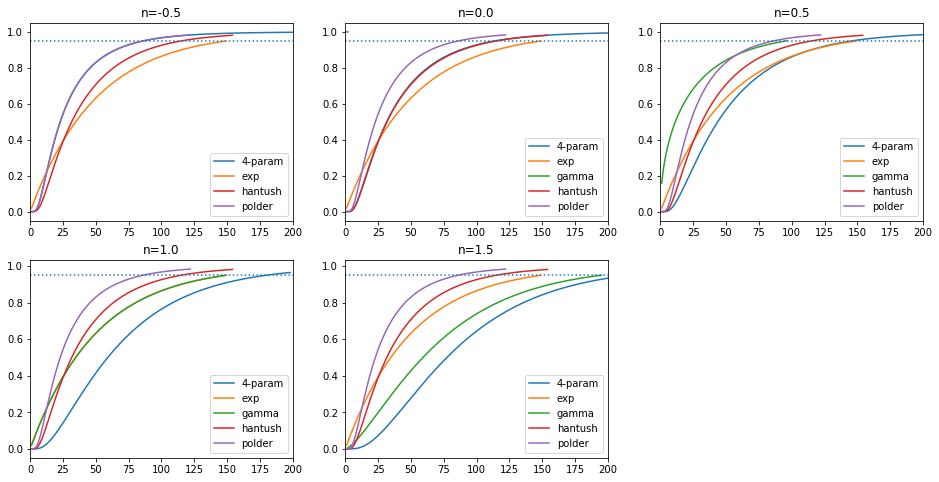

In [17]:
A = 1
a = 50
b = 0.4
plt.figure(figsize=(16, 8))
for i, n in enumerate([-0.5, 1e-6, 0.5, 1, 1.5]):
    plt.subplot(2, 3, i + 1)
    plt.title(f'n={n:0.1f}')
    fp = fourp.step([A, n, a, b], dt=1, cutoff=0.95)
    plt.plot(np.arange(1, len(fp) + 1), fp, 'C0', label='4-param')
    e = exp.step([A, a], dt=1, cutoff=0.95)
    plt.plot(np.arange(1, len(e) + 1), e, 'C1', label='exp')
    if n > 0:
        g = gamma.step([A, n, a], dt=1, cutoff=0.95)
        plt.plot(np.arange(1, len(g) + 1), g, 'C2', label='gamma')
    h = hantush.step([A, a, b], dt=1, cutoff=0.95) / hantush.gain([A, a, b])
    plt.plot(np.arange(1, len(h) + 1), h, 'C3', label='hantush')
    p = polder.step([A, a, b], dt=1, cutoff=0.95) / polder.gain([A, a, b])
    plt.plot(np.arange(1, len(p) + 1), p, 'C4', label='polder')
    plt.xlim(0, 200)
    plt.legend()
    if n > 0:
        print('fp, e, g, h, p:', fp[-1], e[-1], g[-1], h[-1], p[-1])
    else:
        print('fp, e, h, p:', fp[-1], e[-1], h[-1], p[-1])
    plt.axhline(0.95, linestyle=':')